In [21]:
import classes_taskonomy as classes

# modified visualpriors library
from transforms import VisualPriorRepresentation

import os
import pandas as pd

import torch.utils.model_zoo # required to load nets
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor

In [3]:
DATASET_NAMES = ('places1', 'places2', 'oasis')
SCALE_NAMES = ('scale2','scale4','scale8','scale16','scale32')

In [4]:
DATA_PATH = './data_256x256'
BEHAVIOR_PATH = './behavior'
RESULTS_PATH = './results_taskonomy'

In [5]:
#VisualPrior.viable_feature_tasks
MODEL_NAMES = ('autoencoding','depth_euclidean','jigsaw','reshading',
               'edge_occlusion','keypoints2d','room_layout', #'colorization' currently not working
               'curvature','edge_texture','keypoints3d','segment_unsup2d',
               'class_object','egomotion','nonfixated_pose','segment_unsup25d',
               'class_scene','fixated_pose','normal','segment_semantic',
               'denoising','inpainting','point_matching','vanishing_point')


In [5]:
IMAGE_TRANSFORMS = ('untransformed')

# create folder structure

In [1]:
# create folder structure for image
for dataset_name in DATASET_NAMES:
    for scale_name in SCALE_NAMES:
        for version_name in ('full','version1','version2'):
            os.makedirs(os.path.join(DATA_PATH, dataset_name, scale_name, version_name))

NameError: name 'DATASET_NAMES' is not defined

In [ ]:
# create folder structure for results
for model_name in MODEL_NAMES:
    for dataset_name in DATASET_NAMES:
        for scale_name in SCALE_NAMES:
            dir_path = os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name)
            os.makedirs(dir_path)

In [ ]:
# create folder strucutre for Pytorch -> Matlab converted results
for model_name in MODEL_NAMES:
    os.makedirs(os.path.join('../matlab analysis', 'data taskonomy', model_name))


In [ ]:
# create folder strucutre for Matlab -> Python converted results (analysis results)
STUDY_NAMES = ('short presentation','long presentation','complexity order','oasis')

for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:
            os.makedirs(os.path.join('./analysis results taskonomy', model_name, study_name, scale_name))


# model analysis

In [6]:
for model_name in MODEL_NAMES:
    print(model_name)

    # Import taskonomy model...
    VisualPriorRepresentation._load_unloaded_nets([model_name])
    net = VisualPriorRepresentation.feature_task_to_net[model_name]
    
    # ...and create activation extractor from it
    _, eval_nodes = get_graph_node_names(net)
    return_nodes = { node:node for node in eval_nodes if "conv" in node or 'fc' in node}
    activation_extractor = create_feature_extractor(net, return_nodes=return_nodes)


    for dataset_name in DATASET_NAMES:
        print(dataset_name)

        for scale_name in SCALE_NAMES:
            
            dataset = classes.ImageDataset(
                os.path.join(DATA_PATH, dataset_name, scale_name))
                        
            correlations, selfsimilarity, l2norm = classes.calculate_dataset_metrics(dataset, activation_extractor)
            
            correlations.fillna(correlations.mean())
            selfsimilarity.fillna(selfsimilarity.mean())
            l2norm.fillna(l2norm.mean())
            
            correlations.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'correlations.csv'), index=False, header=False)
            selfsimilarity.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)           
            l2norm.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

autoencoding
places1


/home/max/miniconda3/envs/PytorchEnv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/max/miniconda3/envs/PytorchEnv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/max/miniconda3/envs/PytorchEnv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/max/miniconda3/envs/PytorchEnv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/max/minico

places2
oasis
depth_euclidean
places1
places2
oasis
jigsaw
places1
places2
oasis
reshading
places1
places2
oasis
edge_occlusion
places1
places2
oasis
keypoints2d
places1
places2
oasis
room_layout
places1
places2
oasis
curvature
places1
places2
oasis
edge_texture
places1
places2
oasis
keypoints3d
places1
places2
oasis
segment_unsup2d
places1
places2
oasis
class_object
places1
places2
oasis
egomotion
places1
places2
oasis
nonfixated_pose
places1
places2
oasis
segment_unsup25d
places1
places2
oasis
class_scene
places1
places2
oasis
fixated_pose
places1
places2
oasis
normal
places1
places2
oasis
segment_semantic
places1
places2
oasis
denoising
places1
places2
oasis
inpainting
places1
places2
oasis
point_matching
places1
places2
oasis
vanishing_point
places1
places2
oasis


# inspect results

## raw integration

In [201]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

In [215]:
# load results
data_list = []


for model_name in MODEL_NAMES:
    for dataset_name in DATASET_NAMES:
        for scale_name in SCALE_NAMES:

            data = pd.read_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'correlations.csv'), header=None)
            data.insert(0, 'scale', scale_name)
            data.insert(0, 'dataset',dataset_name)
            data.insert(0, 'model', model_name)

            data_list.append(data)
            #selfsimilarity.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)           
            #l2norm.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

In [216]:
# convert correlation to integration
df = - pd.concat(data_list).set_index(['model','dataset','scale'])

In [217]:
# block layers
df = df.T.set_index(np.insert(np.repeat(range(2,17+1), 3), 0, 1)).T.groupby(level=0,axis=1).mean()
df

1         2         3         4   \
model           dataset scale                                             
autoencoding    places1 scale2  -0.999991 -0.954867 -0.964508 -0.945294   
                        scale2  -0.999955 -0.908275 -0.938036 -0.916033   
                        scale2  -0.999948 -0.882310 -0.920534 -0.904163   
                        scale2  -0.999968 -0.934735 -0.949267 -0.931812   
                        scale2  -0.999962 -0.909415 -0.937937 -0.925427   
...                                   ...       ...       ...       ...   
vanishing_point oasis   scale32 -0.999956 -0.645873 -0.655598 -0.644939   
                        scale32 -0.999994 -0.458810 -0.493229 -0.531456   
                        scale32 -0.999986 -0.685778 -0.674535 -0.680692   
                        scale32 -0.999987 -0.490763 -0.364648 -0.458664   
                        scale32 -0.999964 -0.864762 -0.832606 -0.820135   

                                       5         6         7         8   \
model           dataset scale                                             
autoencoding    places1 scale2  -0.960083 -0.954185 -0.959616 -0.960868   
                        scale2  -0.912211 -0.906948 -0.921349 -0.945442   
                        scale2  -0.889905 -0.895283 -0.920993 -0.940898   
                        scale2  -0.938756 -0.941886 -0.954637 -0.961233   
                        scale2  -0.922399 -0.925180 -0.935713 -0.943861   
...                                   ...       ...       ...       ...   
vanishing_point oasis   scale32 -0.614663 -0.518663 -0.585089 -0.617287   
                        scale32 -0.588290 -0.556416 -0.502851 -0.576104   
                        scale32 -0.680494 -0.612417 -0.621485 -0.611207   
                        scale32 -0.410559 -0.291273 -0.265145 -0.357469   
                        scale32 -0.770511 -0.718473 -0.737169 -0.742509   

                                       9         10        11        12  \
model           dataset scale                                             
autoencoding    places1 scale2  -0.965992 -0.965219 -0.978298 -0.987829   
                        scale2  -0.902756 -0.890708 -0.938525 -0.966740   
                        scale2  -0.911969 -0.907695 -0.962481 -0.986017   
                        scale2  -0.953549 -0.973342 -0.982435 -0.984104   
                        scale2  -0.932496 -0.939480 -0.966701 -0.907089   
...                                   ...       ...       ...       ...   
vanishing_point oasis   scale32 -0.682188 -0.630977 -0.560359 -0.652606   
                        scale32 -0.587000 -0.607113 -0.588332 -0.551323   
                        scale32 -0.631390 -0.511655 -0.546500 -0.531646   
                        scale32 -0.312168 -0.400117 -0.135308 -0.296639   
                        scale32 -0.771924 -0.739510 -0.720743 -0.725126   

                                       13        14        15        16  \
model           dataset scale                                             
autoencoding    places1 scale2  -0.990315 -0.985722 -0.962560 -0.922287   
                        scale2  -0.946247 -0.964382 -0.871769 -0.567526   
                        scale2  -0.973795 -0.959324 -0.878616 -0.524616   
                        scale2  -0.985400 -0.980480 -0.948330 -0.687832   
                        scale2  -0.957674 -0.956597 -0.878096 -0.537744   
...                                   ...       ...       ...       ...   
vanishing_point oasis   scale32 -0.623889 -0.710526 -0.773811 -0.730414   
                        scale32 -0.693906 -0.634368 -0.743790 -0.688912   
                        scale32 -0.501955 -0.632801 -0.765127 -0.712645   
                        scale32 -0.314013 -0.574552 -0.641993 -0.547555   
                        scale32 -0.618242 -0.847730 -0.884148 -0.803208   

                                       17  
model           dataset scale              
autoencoding    places1 scale2  -0.881077  
   

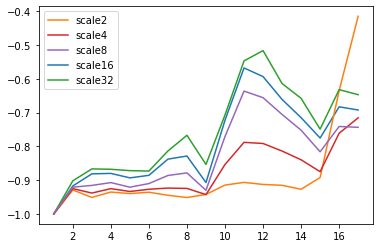

In [218]:
handles, labels = df.loc['autoencoding'].groupby('scale').mean().transpose().plot().get_legend_handles_labels()
order = [1, 3, 4, 0, 2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

In [254]:
with PdfPages('Mean integration per model') as pdf:
    for model_name in MODEL_NAMES:
        handles, labels = df.loc[model_name].groupby('scale').mean().T.plot().get_legend_handles_labels()
        order = [1, 3, 4, 0, 2]
        plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
        plt.title(model_name)
        plt.ylim((-1,.05))
        plt.xlabel('DNN layer')
        plt.ylabel('integration coefficient (mean over places1)')
        pdf.savefig()
        plt.close()

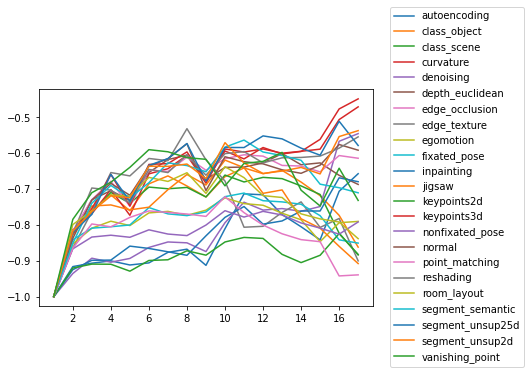

In [223]:
ax = df.loc[:,'places1',:].groupby('model').mean().T.plot()
ax.legend(loc='upper center', bbox_to_anchor=(1.25, 1.4))

In [240]:
df.loc[:,'places1',:].groupby(['model','scale']).mean()

1         2         3         4         5   \
model           scale                                                       
autoencoding    scale16 -0.999972 -0.916270 -0.877147 -0.877045 -0.894301   
                scale2  -0.999972 -0.924277 -0.948362 -0.932835 -0.937145   
                scale32 -0.999972 -0.902088 -0.861247 -0.864856 -0.877159   
                scale4  -0.999972 -0.921042 -0.935231 -0.922761 -0.931325   
                scale8  -0.999972 -0.917990 -0.912002 -0.904637 -0.919367   
...                           ...       ...       ...       ...       ...   
vanishing_point scale16 -0.999974 -0.724388 -0.634142 -0.583355 -0.528336   
                scale2  -0.999974 -0.911760 -0.832339 -0.834248 -0.788349   
                scale32 -0.999974 -0.614097 -0.594496 -0.619773 -0.624868   
                scale4  -0.999974 -0.868064 -0.779760 -0.729102 -0.677895   
                scale8  -0.999974 -0.804211 -0.709645 -0.637940 -0.577011   

                               6         7         8         9         10  \
model           scale                                                       
autoencoding    scale16 -0.886978 -0.832798 -0.824522 -0.906278 -0.750542   
                scale2  -0.933711 -0.939850 -0.948164 -0.938958 -0.915768   
                scale32 -0.874399 -0.811929 -0.771581 -0.850032 -0.740058   
                scale4  -0.925480 -0.918037 -0.920339 -0.940711 -0.858010   
                scale8  -0.909692 -0.880165 -0.874055 -0.928559 -0.788429   
...                           ...       ...       ...       ...       ...   
vanishing_point scale16 -0.471693 -0.456975 -0.501496 -0.490675 -0.543538   
                scale2  -0.790139 -0.806186 -0.804332 -0.796075 -0.899592   
                scale32 -0.547474 -0.570879 -0.576783 -0.606620 -0.555412   
                scale4  -0.629635 -0.638166 -0.648189 -0.667409 -0.803597   
                scale8  -0.510859 -0.507106 -0.530542 -0.523773 -0.652589   

                               11        12        13        14        15  \
model           scale                                                       
autoencoding    scale16 -0.607726 -0.626654 -0.708391 -0.757983 -0.806923   
                scale2  -0.906612 -0.918432 -0.920265 -0.934948 -0.893714   
                scale32 -0.594930 -0.542114 -0.661190 -0.693846 -0.781149   
                scale4  -0.794364 -0.804466 -0.825080 -0.853153 -0.884754   
                scale8  -0.662731 -0.688528 -0.740145 -0.785967 -0.841724   
...                           ...       ...       ...       ...       ...   
vanishing_point scale16 -0.562467 -0.515852 -0.405181 -0.584636 -0.648094   
                scale2  -0.757083 -0.680750 -0.847218 -0.867131 -0.878097   
                scale32 -0.487475 -0.516352 -0.538887 -0.670584 -0.752704   
                scale4  -0.732530 -0.758737 -0.693660 -0.759779 -0.778871   
                scale8  -0.602272 -0.641694 -0.502913 -0.633406 -0.678033   

                               16        17  
model           scale                        
autoencoding    scale16 -0.718598 -0.729027  
                scale2  -0.611038 -0.382088  
                scale32 -0.668456 -0.680734  
                scale4  -0.761031 -0.714855  
                scale8  -0.771733 -0.778775  
...                           ...       ...  
vanishing_point scale16 -0.507262 -0.647225  
                scale2  -0.818224 -0.857447  
                scale32 -0.696426 -0.744505  
                scale4  -0.653090 -0.743640  
                scale8  -0.533789 -0.665601  

[115 rows x 17 columns]

In [228]:
from sklearn.decomposition import PCA


In [250]:

pca = PCA(n_components=2, svd_solver='full')
df_pca = pca.fit_transform(df.loc[:,:,:].groupby(['model']).mean())


In [251]:
pca.explained_variance_ratio_.cumsum()

array([0.70175419, 0.93133472])

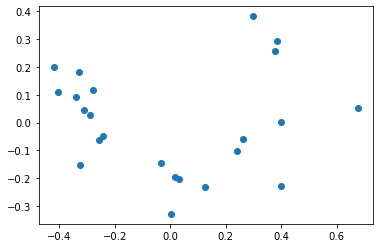

In [252]:
plt.scatter(df_pca[:,0], df_pca[:,1])

In [259]:
# groups
PEAKING = ()

TAIL_UP = ['autoencoding','reshading','curvature','segments_unsup2d','denoising','inpainting']
TAIL_MID = ['depth_euclidean','edge_occlusion','keypoints2d','keypoints3d','egomotion','nonfixated_pose','segment_unsup25d','normal']
TAIL_DOWN = ['jigsaw','room_layout','edge_texture','class_object','class_scene','fixated_pose','point_matching','vanishing_point']
TAIL_UP_AND_DOWN = ['segment_semantic']




## ib correlation

### load data

In [ ]:
# create folder strucutre for Matlab -> Python converted results (analysis results)

for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:
            os.makedirs(os.path.join('./analysis results taskonomy', model_name, study_name, scale_name))


In [256]:
# load results
ANALYSIS_RESULTS_PATH = './analysis results taskonomy'
STUDY_NAMES = ('short presentation','long presentation','complexity order','oasis')

ib_list, ss_list, ibss_list = [],[],[]


for model_name in MODEL_NAMES:
    for study_name in STUDY_NAMES:
        for scale_name in SCALE_NAMES:
            ib = pd.read_csv(os.path.join(ANALYSIS_RESULTS_PATH, model_name, study_name, scale_name, 'ib_correlations.csv'), header=None).transpose()
            ib.insert(0, 'scale', scale_name)
            ib.insert(0, 'study',study_name)
            ib.insert(0, 'model', model_name)
            ib_list.append(ib)


            ss = pd.read_csv(os.path.join(ANALYSIS_RESULTS_PATH, model_name, study_name, scale_name, 'self_similarity.csv'), header=None).transpose()
            ss.insert(0, 'scale', scale_name)
            ss.insert(0, 'study',study_name)
            ss.insert(0, 'model', model_name)
            ss_list.append(ss)


            ibss = pd.read_csv(os.path.join(ANALYSIS_RESULTS_PATH, model_name, study_name, scale_name, 'ib_correlation_ss_partialed.csv'), header=None).transpose()
            ibss.insert(0, 'scale', scale_name)
            ibss.insert(0, 'study',study_name)
            ibss.insert(0, 'model', model_name)
            ibss_list.append(ibss)

            #selfsimilarity.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'selfsimilarity.csv'), index=False, header=False)           
            #l2norm.to_csv(os.path.join(RESULTS_PATH, model_name, dataset_name, scale_name, 'l2norm.csv'), index=False, header=False)

ib_df = pd.concat(ib_list).set_index(['model','study','scale']).rename(columns=lambda x:x+1)
ss_df = pd.concat(ss_list).set_index(['model','study','scale']).rename(columns=lambda x:x+1)
ibss_df = pd.concat(ibss_list).set_index(['model','study','scale']).rename(columns=lambda x:x+1)

### scale x model (all)

In [273]:
['test' 'ab']

['testab']

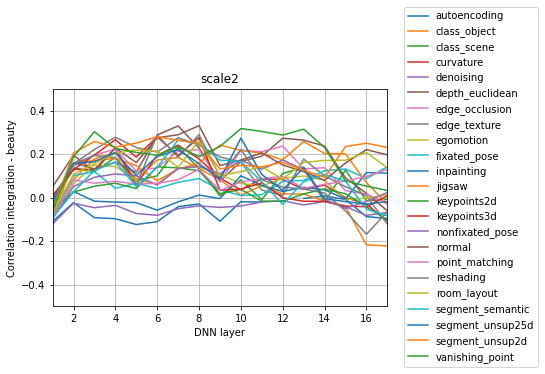

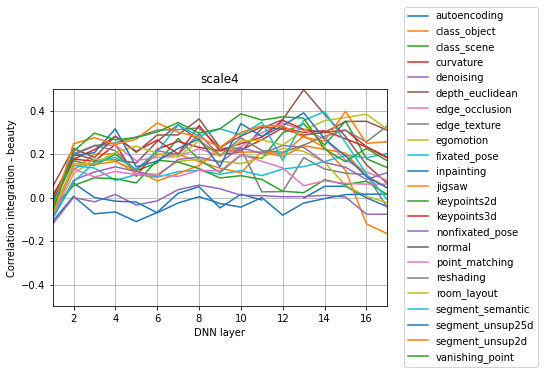

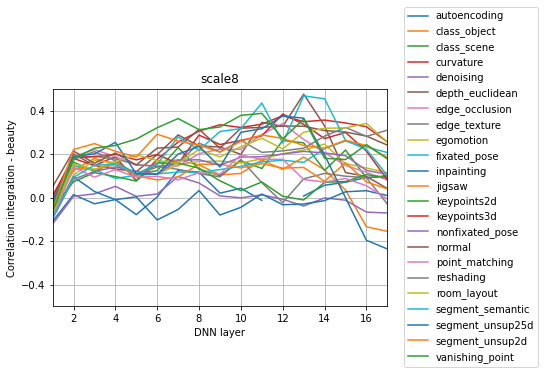

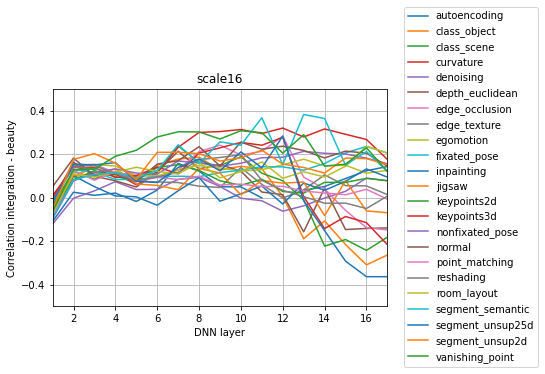

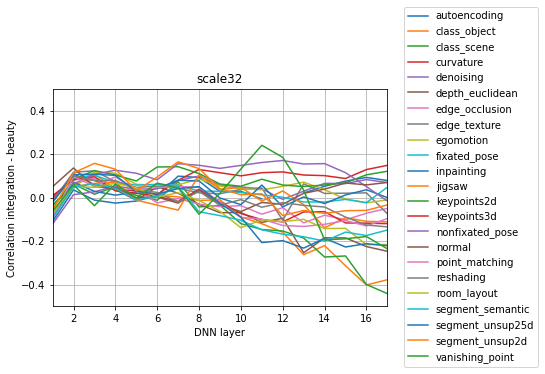

In [276]:
for scale_name in SCALE_NAMES:
        ax = ib_df.loc[:,'short presentation',:].groupby(['scale','model']).mean().loc[scale_name,:].transpose().plot()
        plt.title(scale_name)
        
        plt.xlim((1,17))
        plt.ylim((-.5, .5))
        plt.grid()
        plt.xlabel('DNN layer')
        plt.ylabel('Correlation integration - beauty')
        ax.legend(loc='upper center', bbox_to_anchor=(1.25, 1.4))
        plt.savefig(scale_name+'.png', bbox_inches = 'tight')

In [178]:
STRUCTURAL_TASKS = ['curvature','depth_euclidean','edge_occlusion','keypoints3d',
                    'point_matching','nonfixated_pose','fixated_pose','egomotion',
                    'reshading','room_layout', 'segment_unsup2d', 
                    'normal','vanishing_point']

TEXTURAL_TASKS = ['autoencoding','class_scene','class_object','denoising','edge_texture','inpainting','jigsaw',#'colorization',
                  'keypoints2d','segment_semantic', 'segment_unsup25d']

In [179]:
ib_df.loc[STRUCTURAL_TASKS,:,:]

1         2         3   \
model           study              scale                                   
curvature       short presentation scale2  -0.000352  0.129725  0.129981   
                                   scale4  -0.000352  0.178047  0.167293   
                                   scale8  -0.000352  0.180782  0.147573   
                                   scale16 -0.000352  0.148340  0.107747   
                                   scale32 -0.000352  0.092385  0.080172   
...                                              ...       ...       ...   
vanishing_point oasis              scale2  -0.076538  0.111913  0.137976   
                                   scale4  -0.076538  0.147064  0.171919   
                                   scale8  -0.076538  0.146069  0.162830   
                                   scale16 -0.076538  0.139425  0.145108   
                                   scale32 -0.076538  0.122049  0.121205   

                                                  4         5         6   \
model           study              scale                                   
curvature       short presentation scale2   0.228071  0.059853  0.195127   
                                   scale4   0.245269  0.098775  0.222832   
                                   scale8   0.189273  0.078121  0.175575   
                                   scale16  0.113343  0.059241  0.114034   
                                   scale32  0.038537  0.031410  0.014575   
...                                              ...       ...       ...   
vanishing_point oasis              scale2   0.139501  0.077201  0.084896   
                                   scale4   0.153119  0.133071  0.110252   
                                   scale8   0.142108  0.128898  0.099875   
                                   scale16  0.133533  0.122481  0.083668   
                                   scale32  0.129711  0.123226  0.137252   

                                                  7         8         9   \
model           study              scale                                   
curvature       short presentation scale2   0.241841  0.178246  0.089741   
                                   scale4   0.259407  0.231633  0.216766   
                                   scale8   0.256076  0.306445  0.335677   
                                   scale16  0.231382  0.300352  0.304149   
                                   scale32  0.080298  0.129778  0.114873   
...                                              ...       ...       ...   
vanishing_point oasis              scale2   0.130266  0.103398  0.081946   
                                   scale4   0.156743  0.127093  0.100549   
                                   scale8   0.138832  0.115989  0.086634   
                                   scale16  0.111417  0.108228  0.073513   
                                   scale32  0.156149  0.130202  0.134041   

                                                  10        11        12  \
model           study              scale                                   
curvature       short presentation scale2   0.036600  0.086499  0.083512   
                                   scale4   0.219476  0.266459  0.321786   
                                   scale8   0.323052  0.338131  0.377492   
                                   scale16  0.313659  0.294973  0.320384   
                                   scale32  0.100524  0.115144  0.118567   
...                                              ...       ...       ...   
vanishing_point oasis              scale2   0.102872  0.081332  0.061392   
                                   scale4   0.134957  0.124486  0.110103   
                                   scale8   0.114109  0.123507  0.116182   
                                   scale16  0.075357  0.087178  0.073188   
                                   scale32  0.059798  0.130924  0.104928   

                                                  13        14        15  \
model           st

### scale x model (structural / textural)

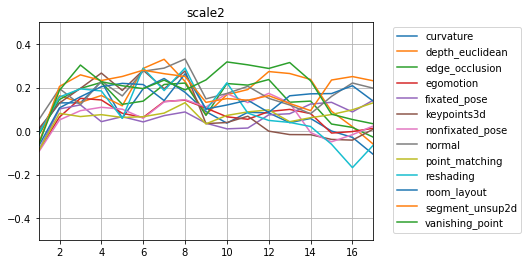

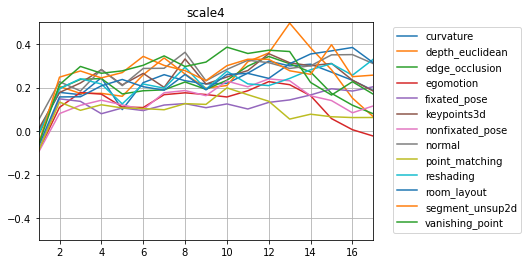

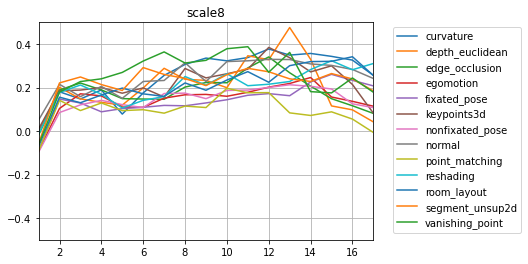

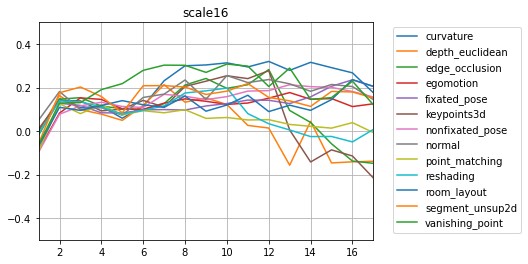

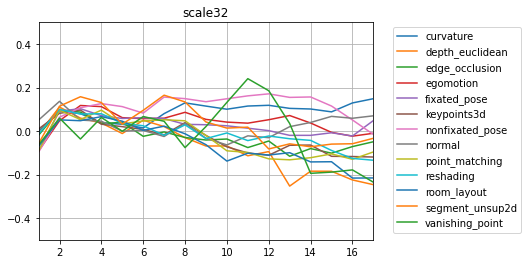

In [184]:
for scale_name in SCALE_NAMES:
    ax = ib_df.loc[STRUCTURAL_TASKS,'short presentation',:].groupby(['scale','model']).mean().loc[scale_name,:].transpose().plot()
    plt.title(scale_name)
    plt.xlim((1,17))
    plt.ylim((-.5, .5))
    plt.grid()
    ax.legend(loc='upper center', bbox_to_anchor=(1.25, 1.))

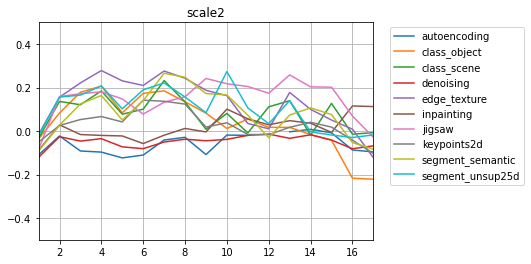

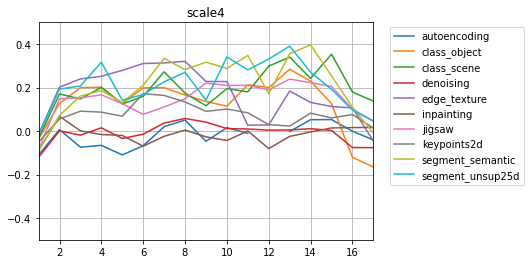

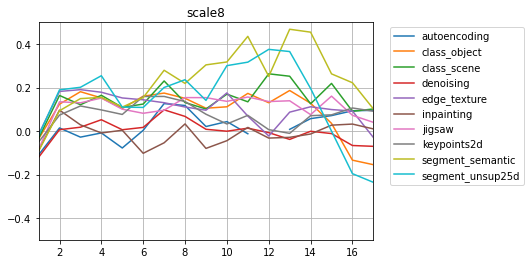

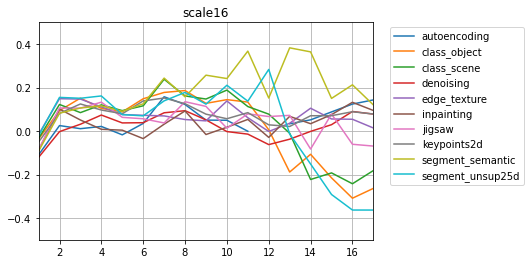

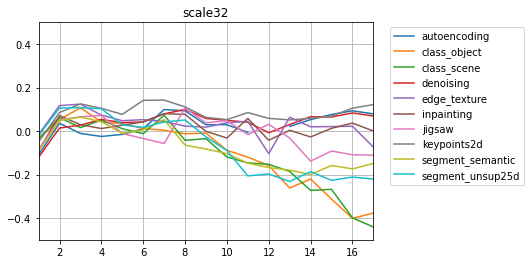

In [185]:
for scale_name in SCALE_NAMES:
    ax = ib_df.loc[TEXTURAL_TASKS,'short presentation',:].groupby(['scale','model']).mean().loc[scale_name,:].transpose().plot()
    plt.title(scale_name)
    plt.xlim((1,17))
    plt.ylim((-.5, .5))
    plt.grid()
    ax.legend(loc='upper center', bbox_to_anchor=(1.25, 1.))

In [173]:
len(STRUCTURAL_TASKS + TEXTURAL_TASKS)

23

In [164]:
import numpy as np

In [171]:
[e for e in STRUCTURAL_TASKS + TEXTURAL_TASKS if e not in ib_df.index.get_level_values('model').values]

['colorization']

### scale x model (raw integration TAIL_UP / TAIL_DOWN)

<ipython-input-263-5659e0306e1d>:2: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  ax = ib_df.loc[TAIL_UP,'short presentation',:].groupby(['scale','model']).mean().loc[scale_name,:].T.plot()
<ipython-input-263-5659e0306e1d>:2: FutureWarning: The behavior of indexing on a MultiIndex with a nested sequence of labels is deprecated and will change in a future version. `series.loc[label, sequence]` will raise if any members of 'sequence' or not present in the index's second level. To retain the old behavior, use `series.index.isin(sequence, level=1)`
  ax = ib_df.loc[TAIL_UP,'short presentation',:].groupby(['scale','model']).mean().loc[scale_name,:].T.plot()
<ipython-input-263-5659e0306e1d>:2: FutureWarning: The beh

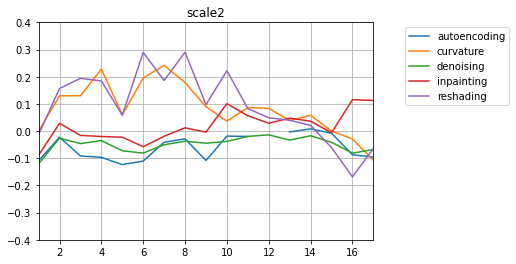

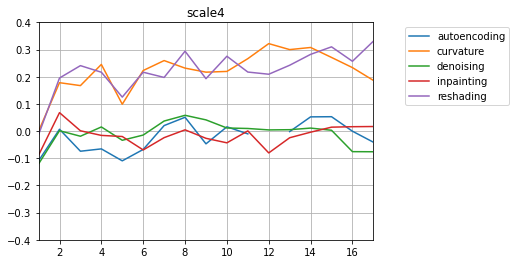

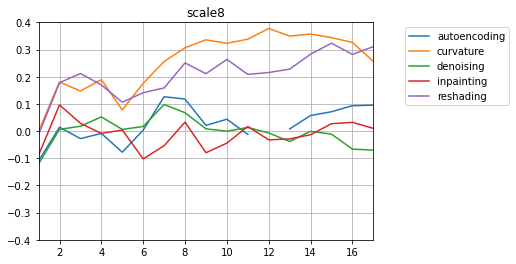

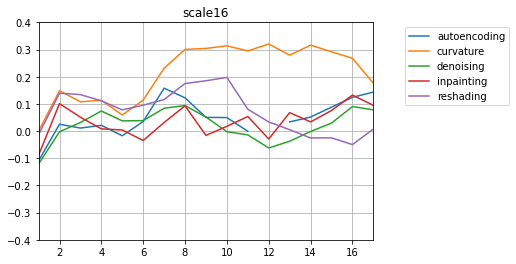

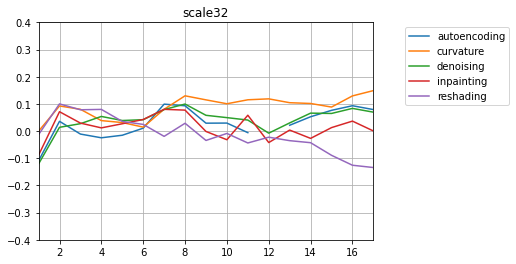

In [263]:
for scale_name in SCALE_NAMES:
    ax = ib_df.loc[TAIL_UP,'short presentation',:].groupby(['scale','model']).mean().loc[scale_name,:].T.plot()
    plt.title(scale_name)
    plt.xlim((1,17))
    plt.ylim((-.4, .4))
    plt.grid()
    ax.legend(loc='upper center', bbox_to_anchor=(1.25, 1.))

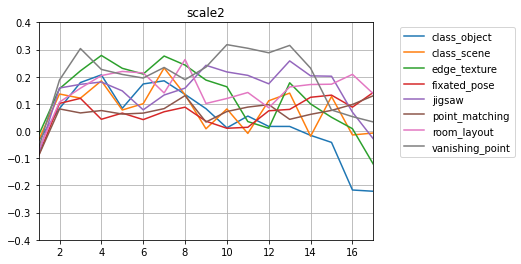

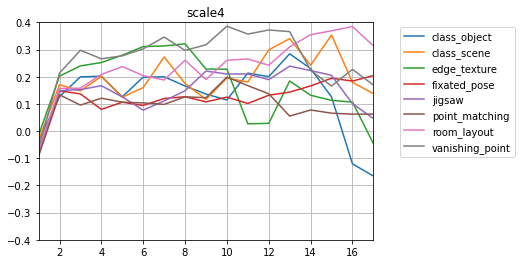

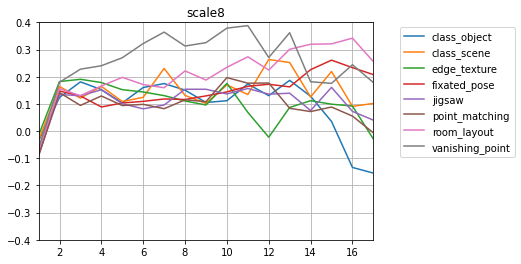

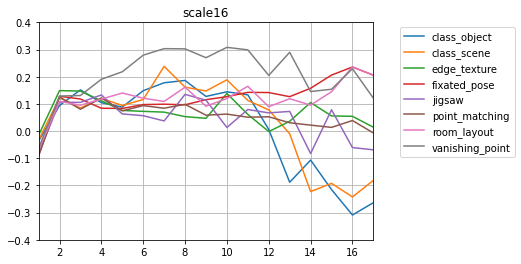

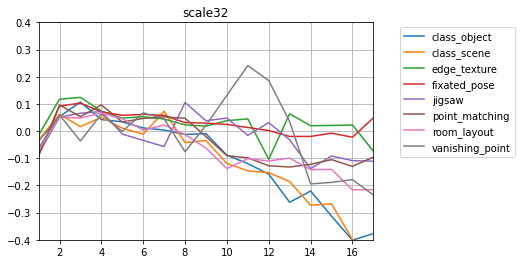

In [264]:
for scale_name in SCALE_NAMES:
    ax = ib_df.loc[TAIL_DOWN,'short presentation',:].groupby(['scale','model']).mean().loc[scale_name,:].T.plot()
    plt.title(scale_name)
    plt.xlim((1,17))
    plt.ylim((-.4, .4))
    plt.grid()
    ax.legend(loc='upper center', bbox_to_anchor=(1.25, 1.))